In [1]:
from src.utils.results_utils import *
from src.utils.ml_utils import *
import pandas as pd
from jellyfish import soundex
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Analysis of the differences in respect to theirs origins

In [2]:
# Read and present the data
df_ethnicity = pd.read_csv('data/name_ethnicity.csv')
df_ethnicity['Country'].value_counts()

Country
English-Speaking               2812
Germanic                       2359
Romance                        1847
Eastern Slavic                 1749
Southern and Western Slavic    1286
Hispanic                        891
Nordic                          882
East Asian                      673
Name: count, dtype: int64

# Creation of the model

In [3]:
find_unusual_characters(df_ethnicity, 'Name')

Number of rows containing special characters: 175
Unusual Characters Found: {'á', 'ë', 'Ã', 'ö', '©', 'ä', 'ü', 'Ö', 'ï', 'è', 'é', 'ç', '¶'}


Encode the Coutries as numbers :

In [4]:
class ColumnEncoder:
    def __init__(self, column_name):
        """
        Initialize the encoder for a specific column.
        """
        self.column_name = column_name
        self.legend = None  # To store the legend of encoded values

    def fit_transform(self, df):
        """
        Encodes the column in the DataFrame as integers and stores the legend.
        """
        if self.column_name not in df.columns:
            raise ValueError(f"Column '{self.column_name}' not found in DataFrame.")
        
        # Factorize the column and store the legend
        df[self.column_name], self.legend = pd.factorize(df[self.column_name])
        return df

    def get_legend(self):
        """
        Generates a DataFrame containing the legend of encoded values.
        """
        if self.legend is None:
            raise ValueError("The encoder has not been fitted. Call `fit_transform` first.")
        
        legend_df = pd.DataFrame({
            'Encoded Value': range(len(self.legend)),
            self.column_name: self.legend
        })
        return legend_df
    
    def inverse_transform(self, encoded_values):
        """
        Decodes the encoded values back to the original labels.
        """
        if self.legend is None:
            raise ValueError("The encoder has not been fitted. Call `fit_transform` first.")
        
        # Map the encoded values back to original labels
        reverse_mapping = {i: label for i, label in enumerate(self.legend)}
        return encoded_values.map(reverse_mapping)

In [5]:
# Encode the column in the DataFrame
encoder = ColumnEncoder(column_name='Country')
df_ethnicity = encoder.fit_transform(df_ethnicity)

# Get the legend 
legend_df = encoder.get_legend()
print("Legend:")
legend_df.head(14)


Legend:


,Encoded Value,Country
0,0,Southern and Western Slavic
1,1,Eastern Slavic
2,2,Nordic
3,3,Romance
4,4,East Asian
5,5,Germanic
6,6,English-Speaking
7,7,Hispanic


In [6]:
with open('country_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [7]:
df_ethnicity.sample(5)

,Name,Country
3099,Yuko,4
3832,Violet,6
10529,Viking,2
7462,Tim,6
3500,Jose,7


## 1. Name Lenght, Vowel/Consonant Count and Ratio, Soundex and N-Gram

In [8]:
# Process df_ethnicity
processor = NameFeatureProcessor('Name',ngram_range=(2, 3))
df_ethnicity_processed = processor.process(df_ethnicity)

df_ethnicity_processed.head()

,Name,Country,name_length,vowel_count,consonant_count,ã,ï,è,ë,ä,...,ž_l,â_l,Í_l,È_l,ō_l,î_l,ñ_l,ó_l,Õ_l,ò_l
0,Vaclav,0,6,2,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allan,1,5,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Kristine,2,8,3,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Matteo,3,6,3,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Isao,4,4,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Par rapport à Soundex :** Phonetic algorithm designed to index words (particularly names) based on their pronunciation rather than their spelling. This is especially useful when trying to find names that sound similar but are spelled differently.

## 2. Scaling features and PCA

In [9]:
# class PCAProcessor:
#     def __init__(self, n_components=100):
#         """
#         Initialize the PCAProcessor with a specified number of components.
#         """
#         self.n_components = n_components
#         self.scaler = StandardScaler()
#         self.pca = PCA(n_components=n_components)
#         self.pca_features = None
#         self.explained_variance_ratio_ = None

#     def fit_transform(self, df, drop_columns=None):
#         """
#         Fit the PCA model and transform the input DataFrame.
#         """
#         # Drop specified columns if provided
#         if drop_columns:
#             df_features = df.drop(columns=drop_columns)
#         else:
#             df_features = df.copy()

#         # Standardize the data
#         features_scaled = self.scaler.fit_transform(df_features)

#         # Apply PCA
#         self.pca_features = self.pca.fit_transform(features_scaled)
#         self.explained_variance_ratio_ = self.pca.explained_variance_ratio_

#         # Create a DataFrame for the PCA-transformed data
#         pca_columns = [f'PC{i+1}' for i in range(self.n_components)]
#         return pd.DataFrame(self.pca_features, columns=pca_columns, index=df.index)

#     def plot_explained_variance(self):
#         """
#         Plot the cumulative explained variance by PCA components.
#         """
#         if self.explained_variance_ratio_ is None:
#             raise ValueError("PCA has not been fitted. Run `fit_transform` first.")
        
#         plt.figure(figsize=(8, 5))
#         plt.plot(self.pca.explained_variance_ratio_.cumsum())
#         plt.title("Cumulative Explained Variance by PCA Components")
#         plt.xlabel("Number of Components")
#         plt.ylabel("Cumulative Explained Variance")
#         plt.grid()
#         plt.show()

#     def merge_with_original(self, original_df, pca_df, keep_columns):
#         """
#         Merge the PCA-transformed DataFrame with the original DataFrame.
#         """
#         # Retain only specified columns and merge with PCA DataFrame
#         merged_df = pd.concat([original_df[keep_columns], pca_df], axis=1)
#         return merged_df

### Tunning of the number of PCA kept components

In [10]:
# from sklearn.decomposition import PCA
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib.pyplot as plt
# import numpy as np

# # List to store results
# results = []

# # Get the number of features in X (ensure it's not less than n_components)
# n_features = X.shape[1]

# # Iterate over the number of PCA components, from 50 to the number of features (n_features), in steps of 10
# for n in range(10, 200, 5):  # Ensure n <= n_features
#     # Apply PCA with n components
#     pca = PCA(n_components=n)
#     X_reduced = pca.fit_transform(X)

#     # Train and evaluate the model with cross-validation
#     model = RandomForestClassifier()
#     scores = cross_val_score(
#         model, X_reduced, y, cv=5, scoring='neg_mean_squared_error'
#     )
#     # Store the mean of absolute MSE scores
#     mean_mse = -np.mean(scores)
#     results.append((n, mean_mse))

# # Find the best number of components
# best_n, best_score = min(results, key=lambda x: x[1])  # Minimize error
# print(f"Best number of components: {best_n}, Lowest MSE: {best_score}")

# # Plot results
# plt.plot([r[0] for r in results], [r[1] for r in results])
# plt.xlabel('Number of Components')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.title('Model Performance vs Number of Components')
# plt.show()

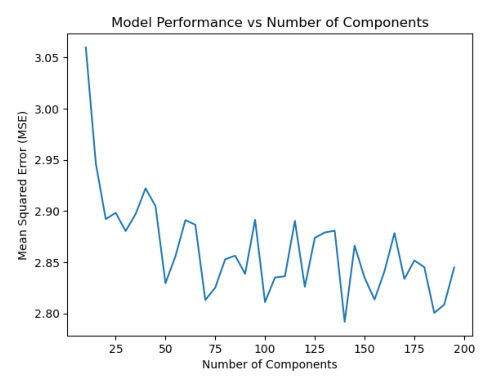

In [11]:
import matplotlib.image as mpimg
# Load and display the evolution of the MSE in respect of n:
img = mpimg.imread('data/Image/best_n.png')
plt.imshow(img)
plt.axis('off')
plt.show()

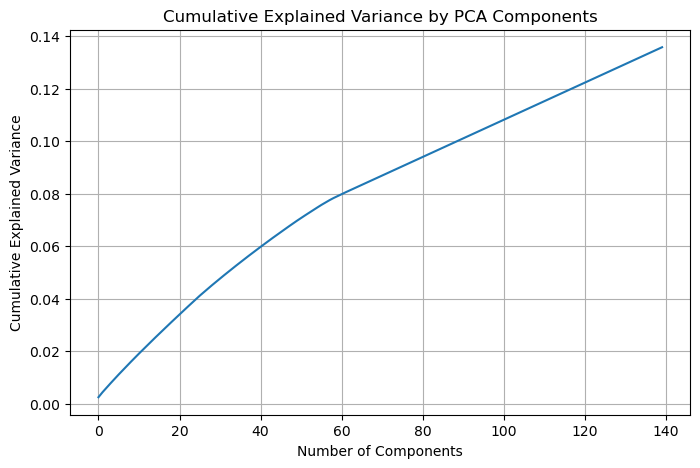

,Name,Country,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140
0,Vaclav,0,2.474357,-0.709759,2.387008,0.043185,-0.414854,-3.436628,0.995259,-1.000666,...,0.060706,0.053866,0.055762,0.121093,-0.037532,-0.002637,-0.028206,-0.005323,0.082353,-0.040172
1,Allan,1,-1.156321,-0.003847,0.649069,0.475963,-1.326890,-0.977950,-0.710894,0.921293,...,-0.258274,0.333825,0.115227,-0.190391,0.062979,-0.393128,0.369067,-0.421203,-0.125768,0.109183
2,Kristine,2,1.528690,-0.289586,-0.524579,1.211715,0.749148,-0.195608,-1.217588,-0.417937,...,-0.135249,-0.359536,-0.341809,0.034921,0.171398,-0.264170,-0.033957,-0.492904,-0.111868,0.303271
3,Matteo,3,0.174506,0.993255,-1.103116,-0.802034,1.630805,0.456306,-1.910192,-0.054607,...,0.063659,0.175246,-0.043276,0.382066,0.401753,-0.005787,0.561863,-0.062213,-0.112668,-0.134252
4,Isao,4,-2.710098,2.156856,1.254629,-1.294791,0.200929,-0.259783,0.523543,-0.573220,...,-1.515997,0.023306,0.083600,-0.418184,-1.403087,-0.509631,-1.223364,0.423065,-0.482535,0.329984


In [12]:
# Choice of number of PCA kept cmponents
n=140

# PCAProcessor
pca_processor = PCAProcessor(n_components=n)
pca_df = pca_processor.fit_transform(df_ethnicity_processed, drop_columns=['Name', 'Country']) # Fit PCA and transform the data
pca_processor.plot_explained_variance() # Plot explained variance
df_ethnicity_pca = pca_processor.merge_with_original(df_ethnicity_processed, pca_df, keep_columns=['Name', 'Country']) # Merge PCA components with original columns ('Name' and 'Country')

df_ethnicity_pca.head()

In [13]:
import pickle

# Save the PCA processor
with open('pca_processor.pkl', 'wb') as f:
    pickle.dump(pca_processor, f)

In [14]:
# Define features and targets
X = df_ethnicity_pca.drop(columns=['Name','Country'])
y = df_ethnicity_pca['Country']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"There are {X_train.shape[0]} samples in the training set.")
print(f"There are {X_test.shape[0]} samples in the testing set.")

There are 9999 samples in the training set.
There are 2500 samples in the testing set.


In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# columns = ["Constant"] + list(df_ethnicity_pca.drop(columns=['Name','Country']).columns) 
# df_X_train = pd.DataFrame(X_train, columns=columns)

In [16]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [17]:
# Initialize the classifier
model = RandomForestClassifier(random_state=42)

# Train the classifier
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.632
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       233
           1       0.77      0.77      0.77       355
           2       0.65      0.38      0.48       183
           3       0.69      0.66      0.67       389
           4       0.76      0.66      0.70       128
           5       0.54      0.61      0.57       446
           6       0.59      0.73      0.65       595
           7       0.46      0.32      0.37       171

    accuracy                           0.63      2500
   macro avg       0.64      0.59      0.61      2500
weighted avg       0.63      0.63      0.63      2500



In [18]:
# Save the model
with open('model_origin.pkl', 'wb') as f:
    pickle.dump(model, f)

# 4 Predict ethnicities of the character dataset

In [19]:
df_character = pd.read_csv('data/cleaned.csv', usecols=['Character_name'])
find_unusual_characters(df_character, 'Character_name')

Number of rows containing special characters: 2055
Unusual Characters Found: {'Þ', 'ã', 'ž', 'Ó', 'ï', 'è', 'Í', 'Õ', 'ë', 'š', 'ä', 'ô', 'ü', 'ß', 'ø', 'Ö', 'Â', 'È', 'ì', 'é', 'ê', 'É', 'á', 'ś', 'ý', 'æ', 'Ô', 'ö', 'ò', 'õ', 'ó', 'í', 'å', 'ð', 'ō', '-', 'ç', 'â', 'û', 'ł', 'ú', 'ñ', 'à', 'ū', 'Å', 'î', 'ù', 'Ø', 'Á', 'À', 'þ'}


In [20]:
df_names = pd.DataFrame(df_character[['Character_name']].rename(columns={'Character_name': 'Name'})).drop_duplicates()

df_names_1000 = df_names.head(10000).reset_index(drop=True)
df_names.shape

(37883, 1)

In [21]:
# Process character_names
processor = NameFeatureProcessor('Name',ngram_range=(2, 3))
character_names_processed = processor.process(df_names_1000)

In [22]:
character_names_processed.sample(10)

,Name,name_length,vowel_count,consonant_count,ã,ï,è,ë,ä,ü,...,ž_l,â_l,Í_l,È_l,ō_l,î_l,ñ_l,ó_l,Õ_l,ò_l
2718,Kunti,5,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1682,Cawthorne,9,3,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9630,Massinissa,10,4,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5775,Serafino,8,4,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7603,Chandan,7,2,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2593,Aloysia,7,5,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9025,Winemiller,10,4,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
533,Fogg,4,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3982,Concorde,8,3,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2644,Cacciavitte,11,5,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
character_names_processed.isna().sum().sum()  # Check for NaN values

0

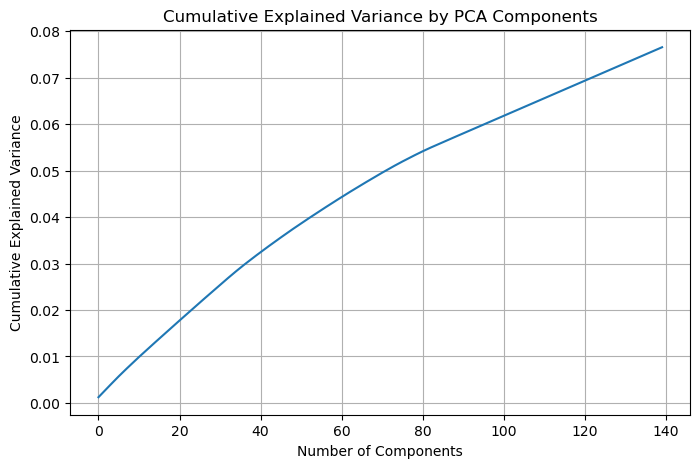

,Name,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140
0,Akooshay,0.125531,-0.291272,-0.238817,0.044339,0.293292,-0.286468,2.759458,1.298411,0.951798,...,-0.140319,-0.260355,0.337912,0.281445,-0.377140,-0.098303,0.273936,-0.274428,0.807686,0.087040
1,Melanie,0.330717,-0.294309,-0.541148,-0.067653,-0.197451,0.272371,2.042783,0.951756,0.534647,...,0.204049,0.030755,-0.017232,-0.049703,-0.240995,0.089943,0.412857,-0.218577,-0.667915,-1.176907
2,Williams,1.809147,0.006349,0.164518,0.183133,-0.207741,-0.268860,-2.433679,-0.944504,-1.088534,...,0.138403,1.427967,-0.800526,-1.389861,-0.150033,-0.534537,0.662020,-0.261271,0.187822,-0.717573
3,Jericho,-0.781128,0.035203,-0.190407,-0.120025,-0.468874,0.500317,-0.369292,-0.042413,-0.433286,...,-0.717416,0.790577,-0.234218,0.966654,0.849139,0.343599,0.087170,0.083101,0.982492,-0.387768
4,Bashira,0.442658,0.134741,0.327815,-0.078015,-0.017419,-0.170581,-0.627013,-0.484627,-0.825861,...,-1.284572,0.377673,-0.952489,-0.832682,0.506712,0.826999,0.293860,0.157537,-0.577304,0.098214


In [24]:
# PCA Processor
character_names_pca = pca_processor.fit_transform(character_names_processed, drop_columns=['Name']) # Fit PCA and transform the data
pca_processor.plot_explained_variance() # Plot explained variance
character_names_pca = pca_processor.merge_with_original(character_names_processed, character_names_pca, keep_columns=['Name']) # Merge PCA components with original columns 

character_names_pca.head()

In [25]:
scaler = StandardScaler()
character_names_pca = scaler.fit_transform(character_names_pca.drop(columns='Name'))
character_names_pca = sm.add_constant(character_names_pca)

encoded_predictions = model.predict(character_names_pca)

In [26]:
# # Create a mapping dictionary from the legend DataFrame
# country_mapping = dict(zip(legend_df['Encoded Value'], legend_df['Country']))

# # Replace the numeric values in the 'Country' column with the corresponding names
# df_names_1000['Country'] = df_names_1000['Country'].map(country_mapping)

encoded_predictions_series = pd.Series(encoded_predictions)
df_names_1000['Country'] = encoder.inverse_transform(encoded_predictions_series)

In [27]:
df_names_1000.sample(50)

,Name,Country
1494,Buela,English-Speaking
3951,Pearl,English-Speaking
265,Harvey,English-Speaking
4856,Kallenberg,English-Speaking
7383,Summerisle,Germanic
2229,Chasen,English-Speaking
7004,Madan,English-Speaking
5224,Hanks,English-Speaking
1005,Hestia,English-Speaking
4637,Wreid,English-Speaking
